In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def count_publications_by_year(file_url: str, sub_area: str) -> pd.DataFrame:
    """
    Loads publication data from a CSV file at the given URL and counts the number of publications per year.

    Parameters:
        file_url (str): URL of the CSV file containing publication data.
                        The CSV is expected to have no header and the first column (index 0) contains the publication year.
        sub_area (str): The sub-area/category (e.g. 'ai', 'se', etc.) associated with the publications.

    Returns:
        pd.DataFrame: A DataFrame with columns ['sub_area', 'year', 'num_publications'].
                      Each row represents a year and the corresponding number of publications for the sub-area.
    """
    try:
        # Load the CSV file from the URL; no header is assumed.
        df = pd.read_csv(file_url, header=None)
    except Exception as e:
        print(f"[ERROR] Failed to load CSV for {sub_area} from {file_url}: {e}")
        # Return an empty DataFrame with the required columns if there is an error.
        return pd.DataFrame(columns=["sub_area", "year", "num_publications"])

    if df.empty:
        print(f"[WARNING] No data found in file {file_url}")
        return pd.DataFrame(columns=["sub_area", "year", "num_publications"])

    # Group by the publication year (assumed to be in the first column, index 0)
    year_counts = df.groupby(df.columns[0]).size().reset_index(name="num_publications")

    # Add the sub_area information to the DataFrame
    year_counts["sub_area"] = sub_area

    # Rearrange columns so that 'sub_area' comes first, followed by 'year' and 'num_publications'
    year_counts = year_counts[["sub_area", df.columns[0], "num_publications"]]
    year_counts.rename(columns={df.columns[0]: "year"}, inplace=True)

    return year_counts

In [3]:
def create_subarea_bar_chart(df: pd.DataFrame) -> None:
    """
    Creates and displays a bar chart of the total number of publications per sub-area.

    Parameters:
        df (pd.DataFrame): A DataFrame containing at least the following columns:
                           - 'sub_area': the sub-area category (e.g., 'ai', 'se', etc.)
                           - 'num_publications': the count of publications (e.g., per year)

    The function aggregates the total publications for each sub-area, sorts them in descending order,
    and displays the chart with the publication count on top of each bar.
    """
    # Aggregate the total number of publications per sub-area
    agg_df = df.groupby("sub_area")["num_publications"].sum().reset_index()

    # Sort by the number of publications in descending order
    agg_df = agg_df.sort_values(by="num_publications", ascending=False)

    # Create the bar chart using Plotly Express
    fig = px.bar(
        agg_df,
        x="sub_area",
        y="num_publications",
        title="Total Number of Publications per Sub-Area",
        labels={"sub_area": "Sub-Area", "num_publications": "Number of Publications"},
        text="num_publications",
        template="plotly_white",
    )

    # Position the text labels above the bars
    fig.update_traces(textposition="outside")

    # Display the interactive chart
    fig.show()

In [4]:
def create_line_chart_publications_per_year(df: pd.DataFrame, sub_areas: list) -> None:
    """
    Creates and displays a line chart of the number of publications per year for the specified sub-areas.

    Parameters:
        df (pd.DataFrame): A DataFrame containing at least the following columns:
                           - 'sub_area': the sub-area category (e.g., 'ai', 'se', etc.)
                           - 'year': the publication year (can be int or str)
                           - 'num_publications': the count of publications for that year
        sub_areas (list): A list of sub-areas to include in the line chart.

    The function filters the DataFrame for the specified sub-areas, aggregates the publication counts per year,
    and creates a line chart with one line per sub-area.
    """
    # Filter the DataFrame for only the selected sub-areas
    filtered_df = df[df["sub_area"].isin(sub_areas)]

    # Aggregate publication counts per sub-area and year in case there are duplicate entries
    agg_df = (
        filtered_df.groupby(["sub_area", "year"])["num_publications"]
        .sum()
        .reset_index()
    )

    # If 'year' is not numeric, try converting it to integer
    try:
        agg_df["year"] = agg_df["year"].astype(int)
    except Exception as e:
        print(f"[INFO] Year column conversion issue: {e}")

    # Create the line chart using Plotly Express
    fig = px.line(
        agg_df,
        x="year",
        y="num_publications",
        color="sub_area",
        markers=True,
        title="Number of Publications per Year by Sub-Area",
        labels={
            "year": "Year",
            "num_publications": "Number of Publications",
            "sub_area": "Sub-Area",
        },
        template="plotly_white",
    )

    # Display the interactive chart
    fig.show()

In [5]:
def build_repo_graph(csv_file: str) -> nx.DiGraph:
    """
    Build a directed graph from the citation edge list CSV.
    
    The CSV is expected to have four columns:
      - origin_doi, origin_sub_area, target_doi, target_sub_area
      
    For each node (publication DOI), the sub_area attribute is taken
    from the available information (either from origin_sub_area or target_sub_area).
    
    Parameters:
        csv_file (str): Path to the CSV file with the edge list.
        
    Returns:
        nx.DiGraph: A directed NetworkX graph with nodes annotated with 'sub_area'.
    """
    # Load the edge list from CSV
    df = pd.read_csv(csv_file)
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Build a mapping from DOI to its sub-area from both origin and target columns.
    # (Assuming that if a node appears as origin, its sub_area is in origin_sub_area,
    # and if as target then in target_sub_area.)
    node_subarea = {}
    for _, row in df.iterrows():
        origin_doi = row["origin_doi"]
        target_doi = row["target_doi"]
        origin_sub = row["origin_sub_area"] if pd.notna(row["origin_sub_area"]) else None
        target_sub = row["target_sub_area"] if pd.notna(row["target_sub_area"]) else None
        
        # Update origin DOI sub-area if not yet set (or if available, you could decide on a priority)
        if origin_doi not in node_subarea:
            node_subarea[origin_doi] = origin_sub or target_sub
        # In case the DOI already exists but has no sub-area and we now have one.
        elif node_subarea[origin_doi] is None and (origin_sub or target_sub):
            node_subarea[origin_doi] = origin_sub or target_sub
        
        if target_doi not in node_subarea:
            node_subarea[target_doi] = target_sub or origin_sub
        elif node_subarea[target_doi] is None and (target_sub or origin_sub):
            node_subarea[target_doi] = target_sub or origin_sub

    # Add all nodes to the graph with the attribute "sub_area"
    for doi, sub_area in node_subarea.items():
        G.add_node(doi, sub_area=sub_area)
    
    # Add edges from the DataFrame
    for _, row in df.iterrows():
        G.add_edge(row["origin_doi"], row["target_doi"])
    
    return G

In [6]:
def draw_graph_plotly(G: nx.DiGraph, sample_fraction: float = 1.0) -> None:
    """
    Draws a sample of a citation network graph using Plotly for interactive visualization.
    
    For large graphs, it samples a percentage of nodes (specified by sample_fraction, between 0.0 and 1.0)
    to avoid clutter. Each node's label displays its sub-area only. Nodes are colored by sub-area,
    and directed edges are visualized with arrow annotations. A legend is added to show the color mapping.
    Node sizes are proportional to their in-degrees.
    
    Parameters:
        G (nx.DiGraph): The directed graph representing the citation network.
        sample_fraction (float): The fraction of nodes to include in the visualization (0.0 to 1.0).
                                 A value of 1.0 includes all nodes.
    """
    # Sample nodes if sample_fraction is less than 1.0
    if sample_fraction < 1.0:
        total_nodes = G.number_of_nodes()
        n_sample = max(1, int(total_nodes * sample_fraction))
        nodes = random.sample(list(G.nodes()), n_sample)
        H = G.subgraph(nodes)
    else:
        H = G

    # Compute positions for the nodes using a spring layout
    pos = nx.spring_layout(H, seed=42)
    
    # Build the edge trace (without arrows)
    edge_x = []
    edge_y = []
    for edge in H.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='gray'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Calculate in-degrees for each node
    in_degrees = dict(H.in_degree())
    
    # Normalize node sizes based on in-degrees
    min_size = 10  # Minimum node size
    max_size = 50  # Maximum node size
    min_degree = min(in_degrees.values(), default=0)
    max_degree = max(in_degrees.values(), default=1)
    node_sizes = {
        node: min_size + (max_size - min_size) * (in_degrees[node] - min_degree) / (max_degree - min_degree)
        if max_degree > min_degree else min_size
        for node in H.nodes()
    }
    
    # Prepare color mapping for each unique sub_area
    unique_sub_areas = list({H.nodes[node].get('sub_area', 'N/A') for node in H.nodes()})
    color_palette = px.colors.qualitative.Plotly  # Use Plotly's qualitative color palette
    color_mapping = {sub_area: color_palette[i % len(color_palette)] 
                     for i, sub_area in enumerate(unique_sub_areas)}
    
    # Group nodes by sub_area for separate traces (for legend support)
    grouped_nodes = {}
    for node in H.nodes():
        sub_area = H.nodes[node].get('sub_area', 'N/A')
        if sub_area not in grouped_nodes:
            grouped_nodes[sub_area] = {"x": [], "y": [], "text": [], "size": []}
        x, y = pos[node]
        grouped_nodes[sub_area]["x"].append(x)
        grouped_nodes[sub_area]["y"].append(y)
        grouped_nodes[sub_area]["text"].append(sub_area)
        grouped_nodes[sub_area]["size"].append(node_sizes[node])
    
    # Create a node trace for each sub_area to get legend items
    node_traces = []
    for sub_area, data in grouped_nodes.items():
        node_trace = go.Scatter(
            x=data["x"],
            y=data["y"],
            mode='markers+text',
            text=data["text"],
            textposition='bottom center',
            hoverinfo='text',
            marker=dict(
                size=data["size"],
                color=color_mapping[sub_area],
                line_width=2
            ),
            name=sub_area  # this name appears in the legend
        )
        node_traces.append(node_trace)
    
    # Create arrow annotations for each edge to simulate directed links
    annotations = []
    for edge in H.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        annotations.append(
            dict(
                ax=x0, ay=y0,
                axref='x', ayref='y',
                x=x1, y=y1,
                xref='x', yref='y',
                showarrow=True,
                arrowhead=3,
                arrowsize=1,
                arrowwidth=1,
                arrowcolor='gray'
            )
        )
    
    # Create the Plotly figure and add both edge and node traces
    fig = go.Figure(
        data=[edge_trace] + node_traces,
        layout=go.Layout(
            title="Citation Network Graph",
            title_font_size=16,
            showlegend=True,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            annotations=annotations,
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )
    )
    
    fig.show()

In [7]:
def filter_graph_by_sub_areas(G: nx.DiGraph, sub_areas: list) -> nx.DiGraph:
    """
    Create a subgraph view containing only nodes from the specified sub-areas.
    
    Parameters:
        G (nx.DiGraph): The original directed graph.
        sub_areas (list): A list of sub-areas to filter by.
        
    Returns:
        nx.DiGraph: A subgraph view with nodes only from the specified sub-areas.
    """
    # Define a filter function for nodes
    def filter_node(n):
        return G.nodes[n].get('sub_area') in sub_areas
    
    # Create a subgraph view using the filter function
    subgraph_view = nx.subgraph_view(G, filter_node=filter_node)
    
    return subgraph_view

In [8]:
def create_citation_matrix(csv_file_path):
    """
    Create a citation matrix showing the number of citations between sub-areas.
    
    Parameters:
        csv_file_path (str): Path to the CSV file containing citation data.
        
    Returns:
        pd.DataFrame: A DataFrame representing the citation matrix.
    """
    # Load the CSV data into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Group by origin_sub_area and target_sub_area, then count the occurrences
    citation_counts = df.groupby(['origin_sub_area', 'target_sub_area']).size().reset_index(name='count')
    
    # Pivot the DataFrame to create the citation matrix
    citation_matrix = citation_counts.pivot(index='origin_sub_area', columns='target_sub_area', values='count')
    
    # Fill NaN values with 0 (indicating no citations)
    citation_matrix = citation_matrix.fillna(0).astype(int)
    
    return citation_matrix


In [9]:
def plot_citation_heatmap(citation_matrix: pd.DataFrame) -> None:
    """
    Plots a heatmap of the citation matrix with annotated values.

    Parameters:
        citation_matrix (pd.DataFrame): A square DataFrame where rows and columns
                                        represent sub-areas, and each cell [i, j]
                                        contains the number of citations from sub-area
                                        i to sub-area j.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(citation_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True,
                xticklabels=citation_matrix.columns, yticklabels=citation_matrix.index)
    plt.title('Citation Matrix Heatmap')
    plt.xlabel('Cited Sub-Area')
    plt.ylabel('Citing Sub-Area')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [10]:
def create_directed_weighted_graph(citation_matrix: pd.DataFrame) -> nx.DiGraph:
    """
    Create a directed, weighted graph from a citation matrix.
    
    Parameters:
        citation_matrix (pd.DataFrame): A DataFrame where rows and columns represent sub-areas,
                                        and each cell contains the number of citations from the
                                        row sub-area to the column sub-area.
                                        
    Returns:
        nx.DiGraph: A directed graph with nodes representing sub-areas and weighted edges
                    representing citation counts.
    """
    # Initialize a directed graph
    G = nx.DiGraph()
    
    # Add nodes (sub-areas)
    sub_areas = citation_matrix.index.tolist()
    G.add_nodes_from(sub_areas)
    
    # Add weighted edges
    for origin in sub_areas:
        for target in sub_areas:
            weight = citation_matrix.at[origin, target]
            if weight > 0:
                G.add_edge(origin, target, weight=weight)
    
    return G

In [11]:
def draw_weighted_directed_graph(G: nx.DiGraph, title: str = "Directed Weighted Citation Graph"):
    """
    Draw a directed, weighted graph using Plotly, with node sizes proportional to in-degrees
    and edge thickness proportional to edge weights.
    
    Parameters:
        G (nx.DiGraph): A directed graph with nodes representing sub-areas and weighted edges.
        title (str): The title of the graph.
    """
    # Compute the layout for node positions
    pos = nx.spring_layout(G, seed=42)  # You can choose other layouts like kamada_kawai_layout

    # Calculate in-degrees for each node
    in_degrees = dict(G.in_degree())

    # Normalize node sizes based on in-degrees
    min_size = 10  # Minimum node size
    max_size = 50  # Maximum node size
    min_degree = min(in_degrees.values())
    max_degree = max(in_degrees.values())
    node_sizes = [
        min_size + (max_size - min_size) * (in_degrees[node] - min_degree) / (max_degree - min_degree)
        if max_degree > min_degree else min_size
        for node in G.nodes()
    ]

    # Extract node positions
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    # Create the node trace
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=[str(node) for node in G.nodes()],
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            size=node_sizes,
            color='lightblue',
            line=dict(width=2)
        )
    )

    # Create the edge traces
    edge_traces = []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2].get('weight', 1)
        edge_trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=weight, color='gray'),  # Adjust width based on weight
            hoverinfo='text',
            mode='lines'
        )
        edge_traces.append(edge_trace)

    # Create the figure
    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title=title,
                        title_font_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))

    fig.show()

In [12]:
base_url = (
    "https://raw.githubusercontent.com/aserg-ufmg/CSIndex/refs/heads/master/data/"
)
# List of sub-areas to process; adjust as necessary.
areas = [
    "ai",
    "arch",
    "bio",
    "chi",
    "cse",
    "data",
    "dbis",
    "ds",
    "formal",
    "graphics",
    "hardware",
    "ir",
    "net",
    "or",
    "pl",
    "robotics",
    "se",
    "security",
    "theory",
    "vision",
]

# List to hold DataFrames for each sub-area.
df_list = []

# Process each sub-area
for area in areas:
    file_url = f"{base_url}{area}-out-papers.csv"
    print(f"[INFO] Processing {area} publications from {file_url}")
    df_area = count_publications_by_year(file_url, area)
    if not df_area.empty:
        df_list.append(df_area)

# Concatenate all sub-area DataFrames into one final DataFrame
if df_list:
    final_df = pd.concat(df_list, ignore_index=True)
    print("[INFO] Combined DataFrame created successfully.")
else:
    final_df = pd.DataFrame(columns=["sub_area", "year", "num_publications"])
    print("[WARNING] No publication data was processed.")

[INFO] Processing ai publications from https://raw.githubusercontent.com/aserg-ufmg/CSIndex/refs/heads/master/data/ai-out-papers.csv
[INFO] Processing arch publications from https://raw.githubusercontent.com/aserg-ufmg/CSIndex/refs/heads/master/data/arch-out-papers.csv
[INFO] Processing bio publications from https://raw.githubusercontent.com/aserg-ufmg/CSIndex/refs/heads/master/data/bio-out-papers.csv
[INFO] Processing chi publications from https://raw.githubusercontent.com/aserg-ufmg/CSIndex/refs/heads/master/data/chi-out-papers.csv
[INFO] Processing cse publications from https://raw.githubusercontent.com/aserg-ufmg/CSIndex/refs/heads/master/data/cse-out-papers.csv
[INFO] Processing data publications from https://raw.githubusercontent.com/aserg-ufmg/CSIndex/refs/heads/master/data/data-out-papers.csv
[INFO] Processing dbis publications from https://raw.githubusercontent.com/aserg-ufmg/CSIndex/refs/heads/master/data/dbis-out-papers.csv
[INFO] Processing ds publications from https://raw.

In [13]:
final_df

,sub_area,year,num_publications
0,ai,2020,115
1,ai,2021,119
2,ai,2022,145
3,ai,2023,111
4,ai,2024,111
...,...,...,...
105,vision,2020,36
106,vision,2021,34
107,vision,2022,28
108,vision,2023,26


In [14]:
final_df.groupby("sub_area")["num_publications"].sum().reset_index().sort_values(
    by="num_publications", ascending=False
)

,sub_area,num_publications
0,ai,602
16,se,441
12,net,339
13,or,270
1,arch,227
9,graphics,219
18,theory,170
5,data,145
19,vision,143
15,robotics,121


In [15]:
create_subarea_bar_chart(final_df)

In [16]:
selected_sub_areas = ["ai", "se", "data", "theory", "security"]  
create_line_chart_publications_per_year(final_df, selected_sub_areas)

In [17]:
csv_file = "../data/citations_edgelist.csv"
    
print("Building the repository citation graph...")
G = build_repo_graph(csv_file)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Building the repository citation graph...
Graph has 1109 nodes and 987 edges.


In [18]:
# Draw a sample of the graph.
draw_graph_plotly(G, sample_fraction=1)

In [19]:
sub_areas_of_interest = ['ai']  # Replace with your desired sub-area
ai_graph = filter_graph_by_sub_areas(G, sub_areas_of_interest)
draw_graph_plotly(ai_graph, sample_fraction=1.0)

In [20]:
sub_areas_of_interest = ['theory']  # Replace with your desired sub-area
theory_graph = filter_graph_by_sub_areas(G, sub_areas_of_interest)
draw_graph_plotly(theory_graph, sample_fraction=1.0)

In [21]:
sub_areas_of_interest = 'bio'  # Replace with your desired sub-area
bio_graph = filter_graph_by_sub_areas(G, sub_areas_of_interest)
draw_graph_plotly(bio_graph, sample_fraction=1.0)

In [22]:
sub_areas_of_interest = ['ai','theory']  # Replace with your desired sub-area
theory_graph = filter_graph_by_sub_areas(G, sub_areas_of_interest)
draw_graph_plotly(theory_graph, sample_fraction=1.0)

In [23]:
sub_areas_of_interest = ['ai','data']  # Replace with your desired sub-area
theory_graph = filter_graph_by_sub_areas(G, sub_areas_of_interest)
draw_graph_plotly(theory_graph, sample_fraction=1.0)

In [24]:
citation_matrix = create_citation_matrix(csv_file)
citation_matrix

target_sub_area,ai,arch,bio,chi,cse,data,dbis,ds,formal,graphics,hardware,ir,net,or,pl,robotics,se,security,theory,vision
origin_sub_area,,,,,,,,,,,,,,,,,,,,
ai,135,2,0,0,0,33,0,0,1,4,1,0,7,15,0,1,1,4,0,2
arch,1,44,0,0,0,0,0,15,0,1,1,0,2,0,1,1,2,1,0,0
bio,0,1,21,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
chi,1,0,0,9,1,0,0,0,0,4,0,1,0,0,0,0,9,0,0,0
cse,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
data,16,0,0,0,0,18,1,2,0,0,1,1,1,4,0,0,0,0,0,2
dbis,1,0,2,0,0,2,22,0,0,2,0,1,0,0,0,0,2,0,0,0
ds,0,13,0,0,0,0,0,3,0,0,0,0,5,0,0,0,2,1,0,0
formal,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


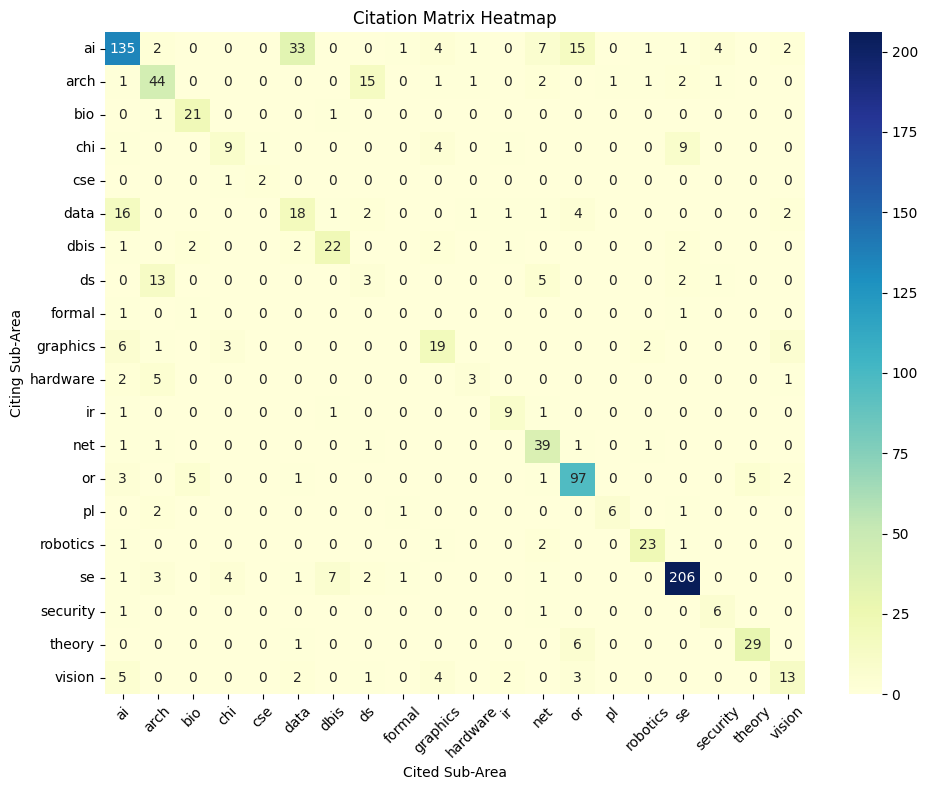

In [25]:
plot_citation_heatmap(citation_matrix)

In [26]:
areas_graph = create_directed_weighted_graph(citation_matrix)

In [27]:
draw_weighted_directed_graph(areas_graph)